Feature engineering for model

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:

# Load EDDMapS data
report = pd.read_csv("CS4824CapstoneData/EDDMapS_clean.csv", encoding='latin-1')
report = report.dropna(subset=['Latitude', 'Longitude'])
report['County'] = report['County'].str.lower()


In [3]:
# FIPS 
fips_df = pd.read_csv(
    "https://raw.githubusercontent.com/kjhealy/fips-codes/refs/heads/master/state_and_county_fips_master.csv"
).dropna()

# County shapefile
counties = gpd.read_file("CS4824CapstoneData/tl_2025_us_county/tl_2025_us_county.shp")

# Urban/rural county classification data
urban_rural = pd.read_csv("CS4824CapstoneData/urban_rural_classification.csv")
urban_rural[["urban_code", "urban_description"]] = urban_rural["2023 Code"].str.split(" - ", expand=True)
urban_rural["urban_code"] = urban_rural["urban_code"].astype(int)

# State lookup
state_lookup = pd.read_csv("CS4824CapstoneData/States2010.csv")
state_lookup["Name"] = state_lookup["Name"].str.lower().str.strip()
state_lookup["Abbrev"] = state_lookup["Abbrev"].str.lower().str.strip()


In [4]:
# Clean FIPS data
fips_df["fips"] = fips_df["fips"].astype(str).str.zfill(5)
fips_df["county_clean"] = (
    fips_df["name"]
    .astype(str)
    .str.replace(" County", "", case=False)
    .str.lower()
    .str.strip()
)
fips_df["state_clean"] = fips_df["state"].astype(str).str.lower().str.strip()

# Clean EDDMapS county/state
report["county_clean"] = (
    report["County"]
    .astype(str)
    .str.replace(" County", "", case=False)
    .str.replace(" Parish", "", case=False)
    .str.lower()
    .str.strip()
)
report["state_clean"] = report["State"].astype(str).str.lower().str.strip()


In [5]:
# Merge abbreviations 
report = report.merge(
    state_lookup[["Name", "Abbrev"]],
    left_on="state_clean", right_on="Name", how="left",
    suffixes=("", "_state")
)

# Determine which column exists
if "Abbrev_state" in report.columns:
    report["state_clean"] = report["Abbrev_state"]
else:
    report["state_clean"] = report["Abbrev"]

# Drop temporary columns
report.drop(columns=[col for col in ["Name", "Abbrev", "Abbrev_state"] if col in report.columns], inplace=True)



# Merge FIPS
report_geo = report.merge(
    fips_df[["fips", "county_clean", "state_clean"]],
    on=["county_clean", "state_clean"], how="left"
)

print("Fraction of missing FIPS codes:", report_geo["fips"].isna().mean())
report_geo[["County", "State", "fips"]].head()


Fraction of missing FIPS codes: 0.012887101183270199


,County,State,fips
0,lehigh,Pennsylvania,42077
1,berks,Pennsylvania,42011
2,berks,Pennsylvania,42011
3,berks,Pennsylvania,42011
4,berks,Pennsylvania,42011


In [6]:
urban_rural["FIPS"] = urban_rural["FIPS code"].astype(str).str.zfill(5)
counties["GEOID"] = counties["GEOID"].astype(str).str.zfill(5)
report_geo["fips"] = report_geo["fips"].astype(str).str.zfill(5)

# Aggregate reports
report_counts = report_geo.groupby("fips").size().reset_index(name="report_count")

# Merge with county map
map_df = counties.merge(report_counts, left_on="GEOID", right_on="fips", how="left")
map_df["report_count"] = map_df["report_count"].fillna(0)


In [7]:
# Merge urban codes with county map
map_df = map_df.merge(
    urban_rural[["FIPS", "urban_code", "urban_description"]],
    left_on="GEOID", right_on="FIPS", how="left"
)
map_df = map_df.dropna(subset=["urban_code"]).drop(columns=["FIPS"])
map_df['urban_code'] = map_df['urban_code'].astype(int)


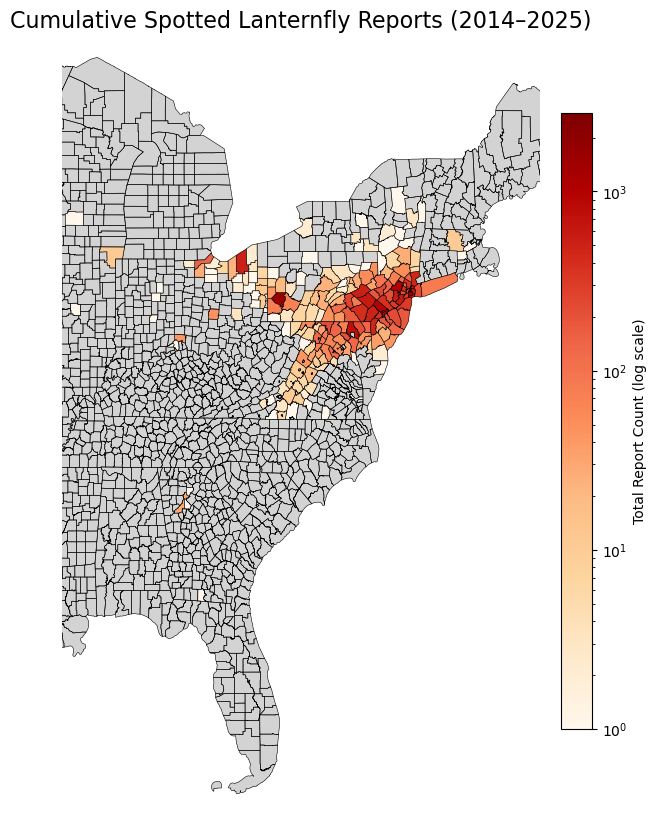

In [8]:
# Plot all SLF reports
minx, miny, maxx, maxy = (-90, 24, -68, 49)
counties_conus = map_df.cx[minx:maxx, miny:maxy]

fig, ax = plt.subplots(figsize=(14, 10))
counties_conus.plot(ax=ax, color="lightgrey", edgecolor="none")
map_df.plot(
    ax=ax, column="report_count", cmap="OrRd",
    linewidth=0.4, edgecolor="black",
    norm=mcolors.LogNorm(vmin=1, vmax=map_df["report_count"].max()),
    legend=True, legend_kwds={
        "label": "Total Report Count (log scale)",
        "orientation": "vertical",
        "shrink": 0.8, "pad": 0.02
    }
)
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Cumulative Spotted Lanternfly Reports (2014–2025)", fontsize=16)
ax.axis("off")
plt.show()

map_df.to_csv('CS4824CapstoneData/map_df_clean.csv', index=False)


In [9]:
# Find county lat and lon centroids
proj_crs = "EPSG:5070"
geo_crs = "EPSG:4326"

map_df = map_df[~map_df.geometry.is_empty & map_df.geometry.notna()].copy()
map_df_proj = map_df.to_crs(proj_crs)
map_df_proj["centroid_proj"] = map_df_proj.geometry.centroid

centroids_geo = gpd.GeoSeries(map_df_proj["centroid_proj"]).set_crs(proj_crs).to_crs(geo_crs)

map_df["centroid_lon"] = centroids_geo.x.values
map_df["centroid_lat"] = centroids_geo.y.values

print("Example centroids:\n", map_df[["GEOID","centroid_lat","centroid_lon"]].head())


Example centroids:
    GEOID  centroid_lat  centroid_lon
0  40075     34.916317    -98.980892
1  46079     44.021939    -97.129383
2  37033     36.393233    -79.333531
3  48377     29.999228   -104.239600
4  39057     39.691503    -83.889814


In [10]:
# Determine which counties are "northern" for urban effectiveness feature
north_threshold = 38.0
map_df["is_northern"] = (map_df["centroid_lat"] >= north_threshold).astype(int)

if "urban_code" not in map_df.columns:
    map_df["urban_code"] = np.nan

if map_df["urban_code"].dtype == object:
    map_df["urban_code_num"] = map_df["urban_code"].astype(str).str.extract(r"^(\d+)").astype(float)
else:
    map_df["urban_code_num"] = pd.to_numeric(map_df["urban_code"], errors="coerce")

map_df["urban_code_num"] = map_df["urban_code_num"].fillna(0)
map_df["urban_effective"] = np.where(map_df["is_northern"] == 1, map_df["urban_code_num"], 0)


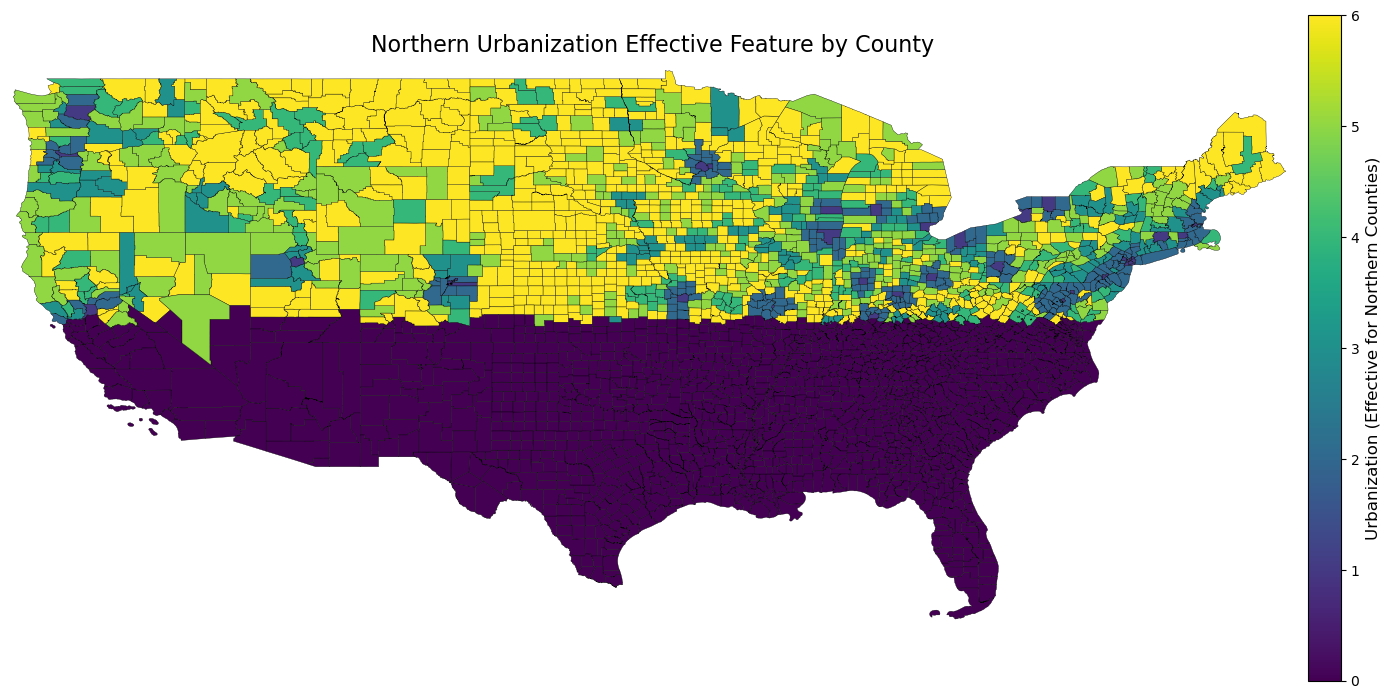

In [11]:
# Plot urban effective feature

minx, miny, maxx, maxy = (-125, 24, -66.5, 49.5)
map_conus = map_df.cx[minx:maxx, miny:maxy]

fig, ax = plt.subplots(figsize=(14, 10))
cmap = plt.cm.viridis
norm = mcolors.Normalize(
    vmin=map_conus["urban_effective"].min(),
    vmax=map_conus["urban_effective"].max()
)
map_conus.plot(
    column="urban_effective", cmap=cmap,
    linewidth=0.25, edgecolor="black", norm=norm, ax=ax
)
ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = fig.colorbar(sm, ax=ax, fraction=0.025, pad=0.01)
cbar.set_label("Urbanization (Effective for Northern Counties)", fontsize=12)
ax.set_title("Northern Urbanization Effective Feature by County", fontsize=16, pad=12)
plt.tight_layout()
plt.show()


In [12]:
# Load tree of heaven data
aial_df = pd.read_csv("CS4824CapstoneData/treeOfHeavenDistributionData.csv")
aial_df = aial_df.dropna(subset=["County"])

aial_df["State FIP"] = aial_df["State FIP"].astype(str).str.replace(r"\.0", "", regex=True).str.zfill(2)
aial_df["County FIP"] = aial_df["County FIP"].astype(str).str.replace(r"\.0", "", regex=True).str.zfill(3)
aial_df["fips"] = aial_df["State FIP"] + aial_df["County FIP"]

# tree of heaven presence classification by county
aial_df["TreeOfHeaven_Present"] = 1
aial_clean = aial_df[["fips", "State", "County", "TreeOfHeaven_Present"]].reset_index(drop=True)
aial_clean["fips"] = aial_clean["fips"].astype(str).str.zfill(5)


In [13]:
# Merge tree of heaven data with county data
counties["GEOID"] = counties["GEOID"].astype(str).str.zfill(5)
counties_tree = counties.merge(aial_clean, left_on="GEOID", right_on="fips", how="left")

# Manually add Connecticut counties
ct_fips = ['09001','09003','09005','09007','09009','09011']
counties_tree.loc[counties_tree['STATEFP'] == '09', 'TreeOfHeaven_Present'] = 1
counties_tree["TreeOfHeaven_Present"] = counties_tree["TreeOfHeaven_Present"].fillna(0)


In [14]:
map_df["GEOID"] = map_df["GEOID"].astype(str).str.zfill(5)
aial_df["fips"] = aial_df["fips"].astype(str).str.zfill(5)
map_df["infested"] = (map_df["report_count"] > 0).astype(int)


features_df = map_df.merge(
    aial_df[["fips", "TreeOfHeaven_Present"]],
    left_on="GEOID", right_on="fips", how="left"
)
features_df["TreeOfHeaven_Present"] = features_df["TreeOfHeaven_Present"].fillna(0).astype(int)

# Create features dataset for model
features_df = features_df[
    ["GEOID", "infested", "report_count", "TreeOfHeaven_Present",
     "urban_code_num", "urban_effective", "centroid_lat", "centroid_lon"]
]

features_df.to_csv('CS4824CapstoneData/features.csv', index=False)
